In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0)
import seaborn as sns
from scipy import stats
from scipy.stats import norm

# Data exploration

### Loading dataset

In [78]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Remark: Target is numeric variable

In [4]:
print(train.shape, test.shape)

(1460, 81) (1459, 80)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

### Checking missing values

In [6]:
train.columns[train.isnull().any()] # train.columns[train.isna().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [27]:
# check the percentage of missing values in these columns
miss = train.isnull().sum() / len(train)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

Electrical      0.000685
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
BsmtExposure    0.026027
BsmtFinType2    0.026027
GarageCond      0.055479
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
GarageYrBlt     0.055479
LotFrontage     0.177397
FireplaceQu     0.472603
Fence           0.807534
Alley           0.937671
MiscFeature     0.963014
PoolQC          0.995205
dtype: float64

### Visualizing missing values

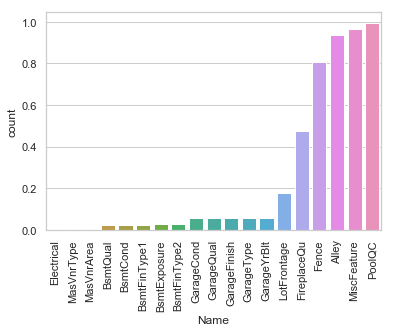

In [28]:
miss = miss.to_frame()
miss.columns = ['count']
miss.index.names = ['Name']
miss['Name'] = miss.index

sns.set(style='whitegrid', color_codes=True)
sns.barplot(x='Name', y='count', data=miss)
plt.xticks(rotation=90)
plt.show()

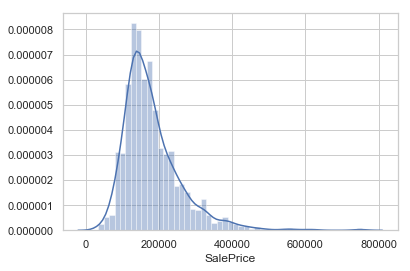

In [29]:
# check the distribution of the target variable.
sns.distplot(train['SalePrice'])

__Remark__:<br>
    . right-skewed distribution => log transform to becomes normally distributed

In [32]:
print('The skewness of SalePrice is {}'.format(train['SalePrice'].skew()))

The skewness of SalePrice is 1.8828757597682129


Skewness is 0.12133506220520406


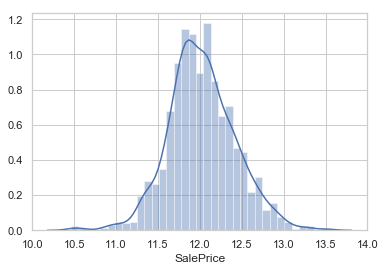

In [31]:
# transform the target variable
target = np.log(train['SalePrice'])
print('Skewness is {}'.format(target.skew()))
sns.distplot(target)

__Remark__:<br>
    . log transformation of the target variable has helped us fixing its skewed distribution and __the new distribution looks closer to normal__

### Separating numeric and categorical variables and explore this

In [33]:
numeric_data = train.select_dtypes(include=[np.number])
cat_data = train.select_dtypes(exclude=[np.number])
print('There is {} numeric and {} categorical columns in train data'.format(numeric_data.shape[1], cat_data.shape[1]))

There is 38 numeric and 43 categorical columns in train data


#### Removing the Id variable from numeric data

In [36]:
del numeric_data['Id']

#### Correlation behavior of numeric variables

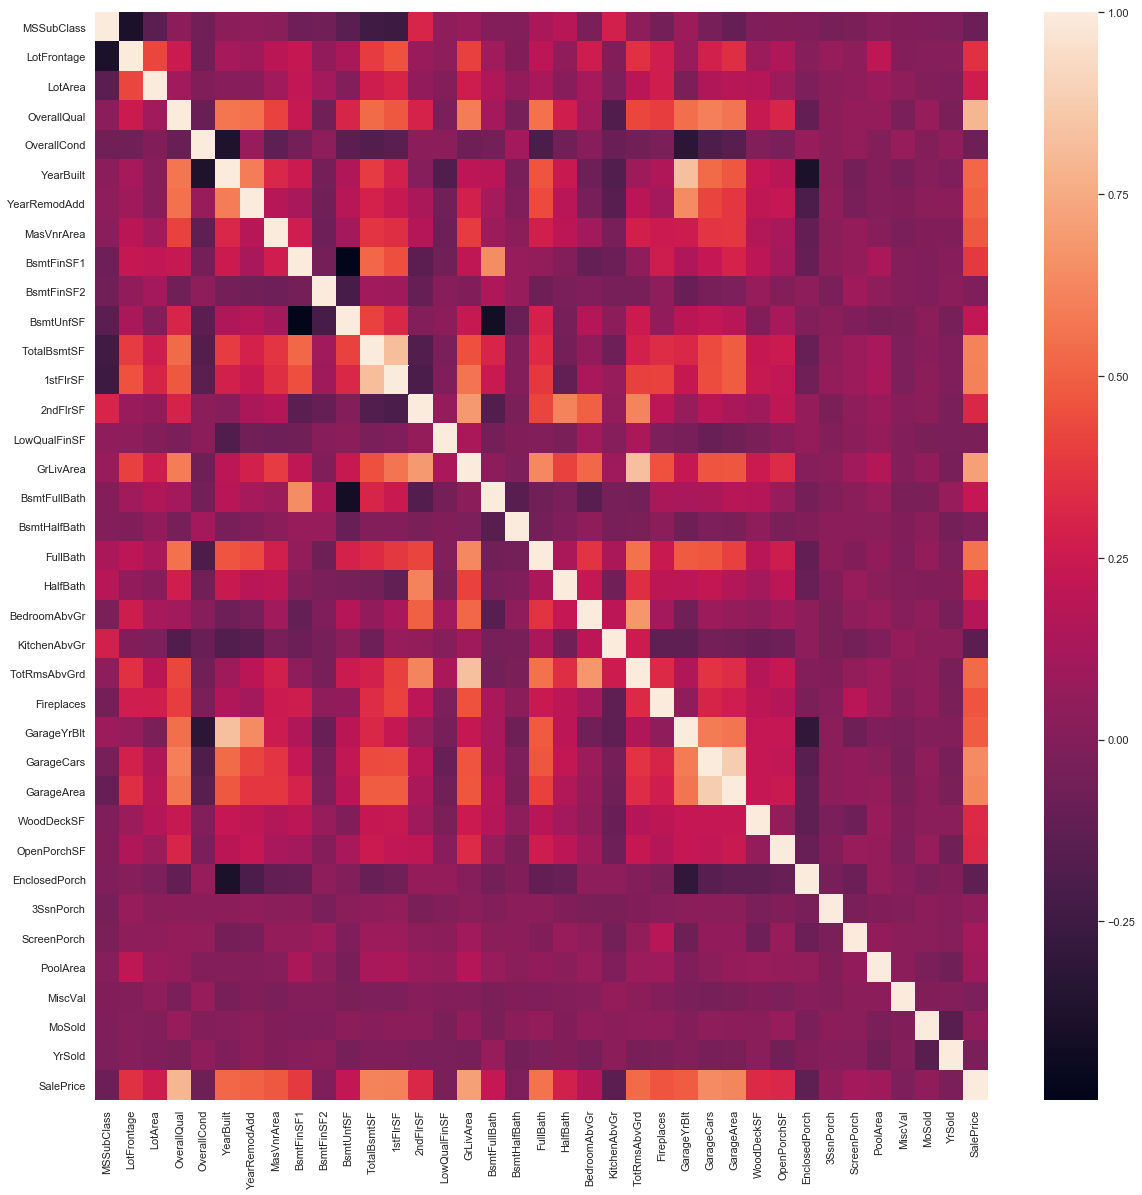

In [41]:
corr = numeric_data.corr()
sns.heatmap(corr)

__Remark__:<br>
    . Last row in this map: the correlation of all variables against SalePrice <br>
      => Some variables seem to be strongly correlated with the target variable

In [42]:
# Top 15 values correlated with the target values
print(corr['SalePrice'].sort_values(ascending=False)[:15])

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64


In [43]:
# Last 5 values 
print(corr['SalePrice'].sort_values(ascending=False)[-5:])

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


### Checking the OverallQual variable in detail

In [44]:
train['OverallQual'].unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2], dtype=int64)

#### Checking median price of house with respect to OverallQual
Why Median???<br>
    . because __the target is skewed__ (A skewed variable has outliers and median is robust to outliers) 

In [47]:
pivot = train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
pivot

,SalePrice
OverallQual,
1,50150
2,60000
3,86250
4,108000
5,133000
6,160000
7,200141
8,269750
9,345000


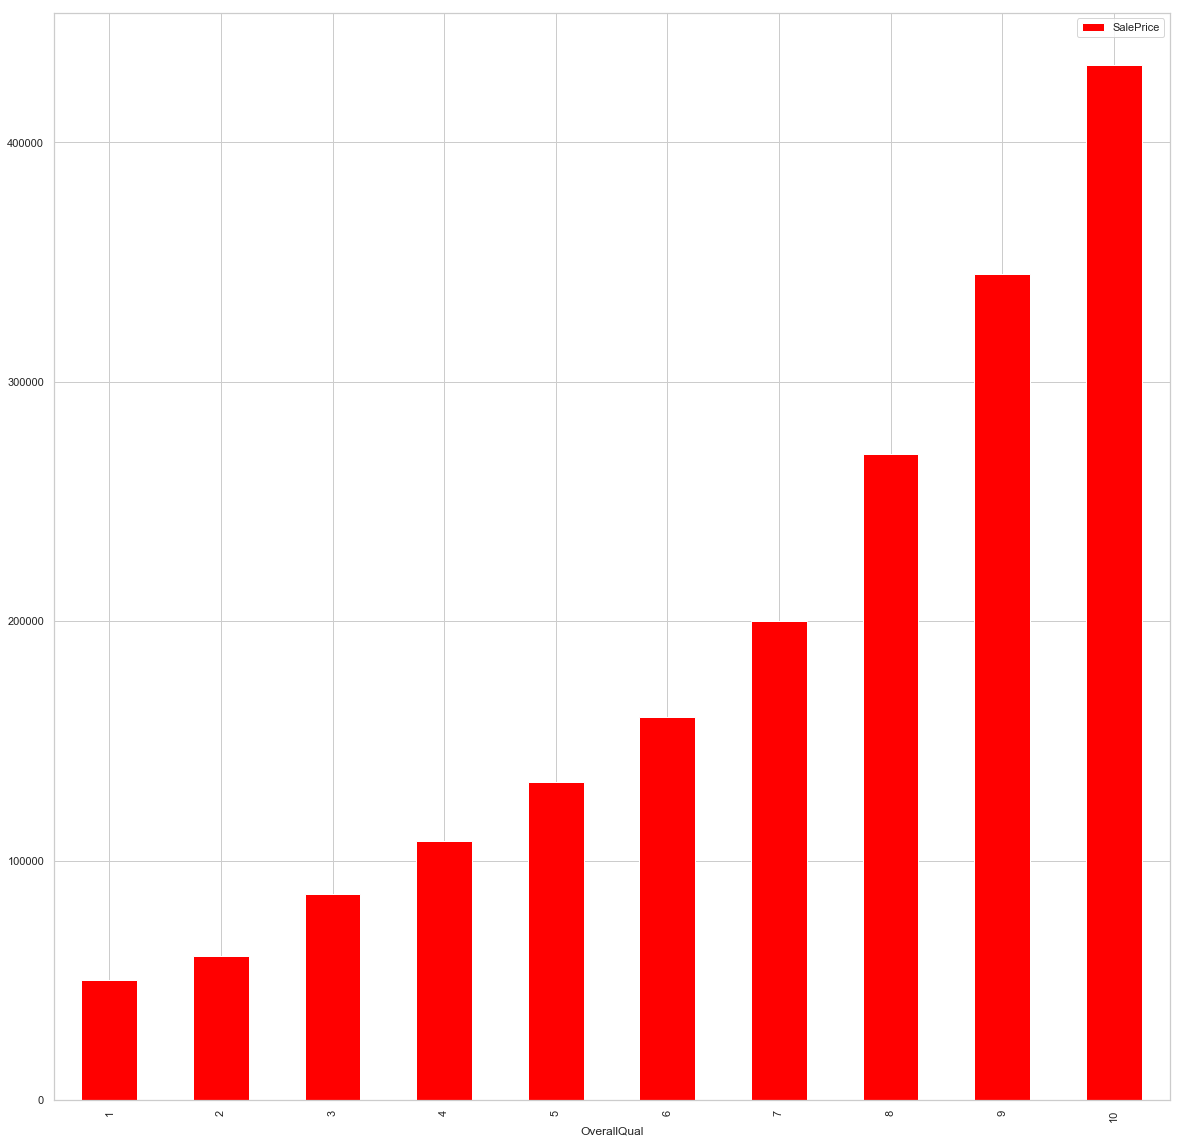

In [49]:
pivot.plot(kind='bar', color='red')

__Remark__:<br>
    . This behavior is quite normal. As the overall quality of house increases, its sale price also increases

### Checking the GrLivArea variable in detail

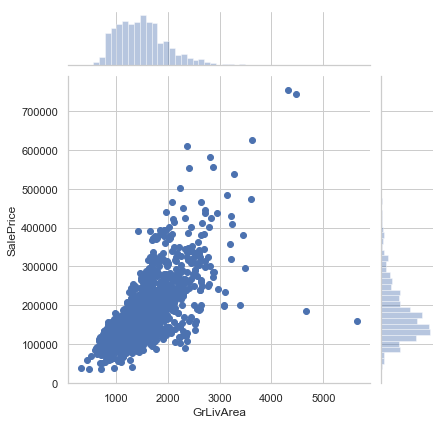

In [52]:
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'])

__Remark__:<br>
    . direct correlation of living area with sale price. However, we have an outlier (__GrLivArea > 4000__)

### Moving forward and explore categorical features

In [53]:
cat_data.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


### Check median of SaleCondition

In [54]:
sale_pivot = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
sale_pivot

,SalePrice
SaleCondition,
Abnorml,130000
AdjLand,104000
Alloca,148145
Family,140500
Normal,160000
Partial,244600


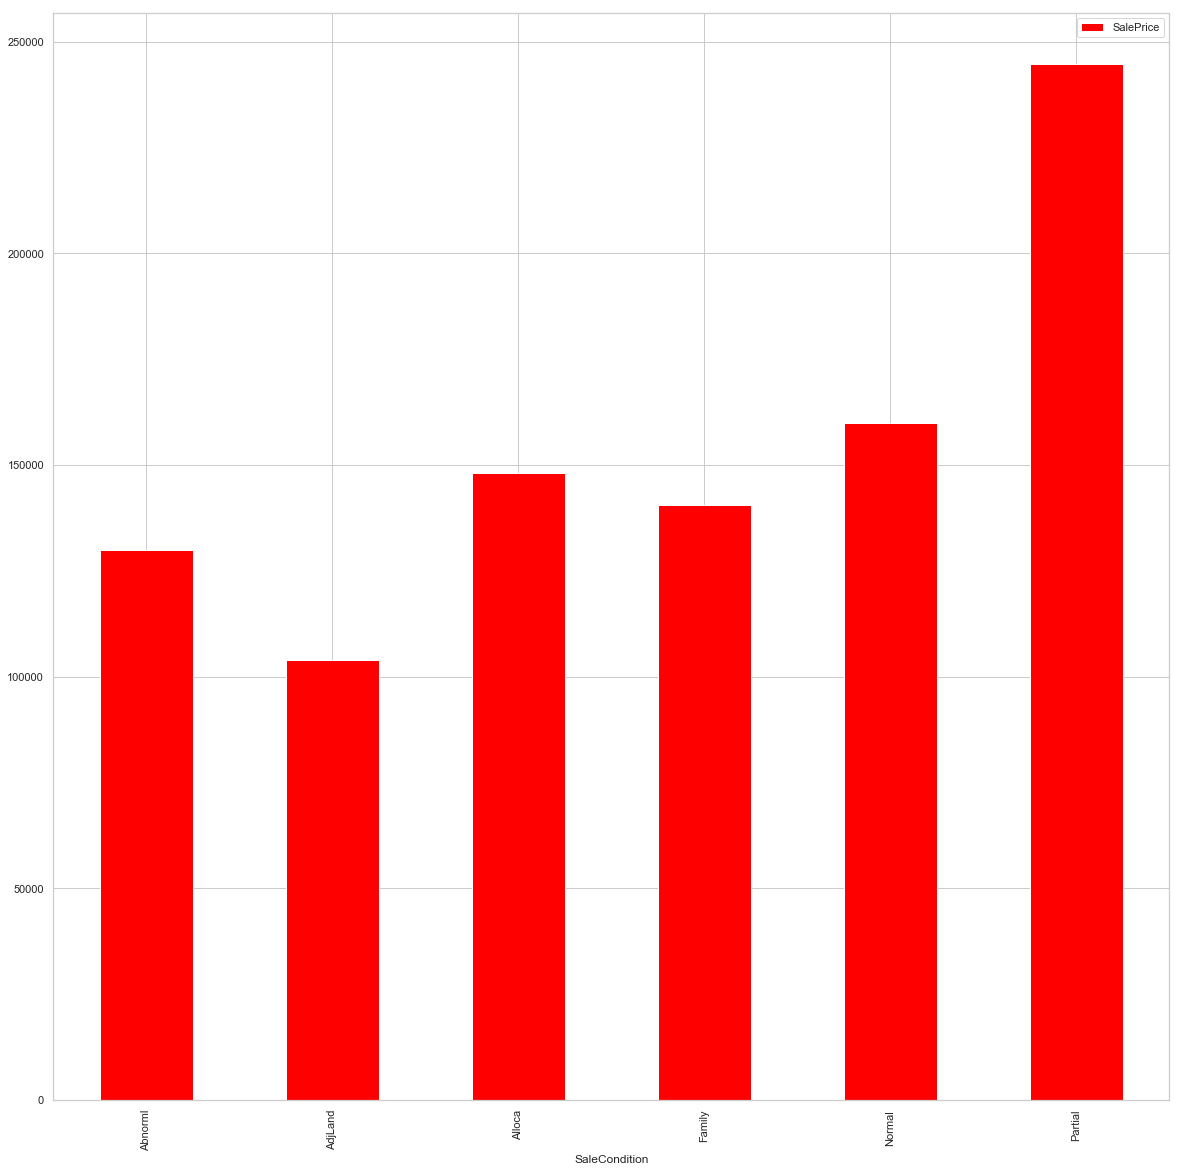

In [55]:
sale_pivot.plot(kind='bar', color='red')

### ANOVA test to understand the correlation between categorical variables and SalePrice
Ho - There exists no significant difference between the groups.<br> Ha - There exists a significant difference between the groups.

In [57]:
cat = [f for f in train.columns if train.dtypes[f] == 'object']
def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = cat
    pvals = []
    for c in cat:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

In [58]:
cat_data['SalePrice'] = train.SalePrice.values
k = anova(cat_data)
k['disparity'] = np.log(1./k['pval'].values)
k

e:\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
e:\python36\lib\site-packages\scipy\stats\stats.py:2951: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / len(a)


,features,pval,disparity
8,Neighborhood,1.558600e-225,517.637858
18,ExterQual,1.439551e-204,469.363028
30,KitchenQual,3.032213e-192,440.987045
20,Foundation,5.791895e-91,207.778784
27,HeatingQC,2.667062e-67,153.292224
42,SaleCondition,7.988268e-44,99.235770
15,Exterior1st,2.586089e-43,98.061012
16,Exterior2nd,4.842186e-43,97.433793
41,SaleType,5.039767e-42,95.091214
0,MSZoning,8.817634e-35,78.413725


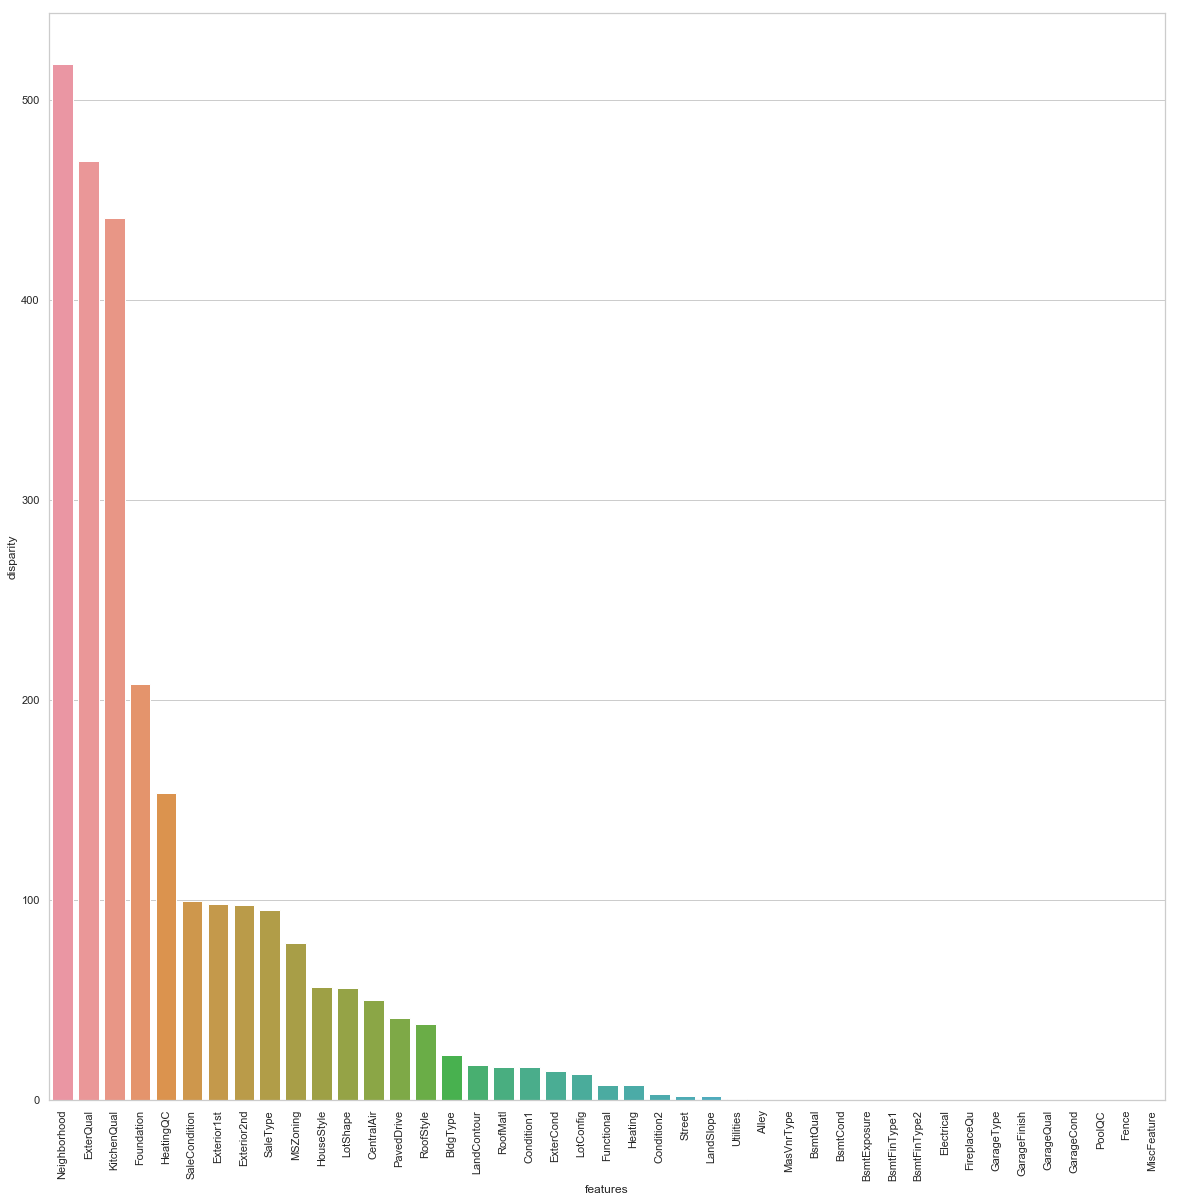

In [59]:
sns.barplot(data=k, x='features', y='disparity')
plt.xticks(rotation=90)
plt.show()

__Remark__:<br>
    . Neighborhood turned out to be the most important feature followed by ExterQual, KitchenQual, etc

### Ploting histograms for all numeric variables

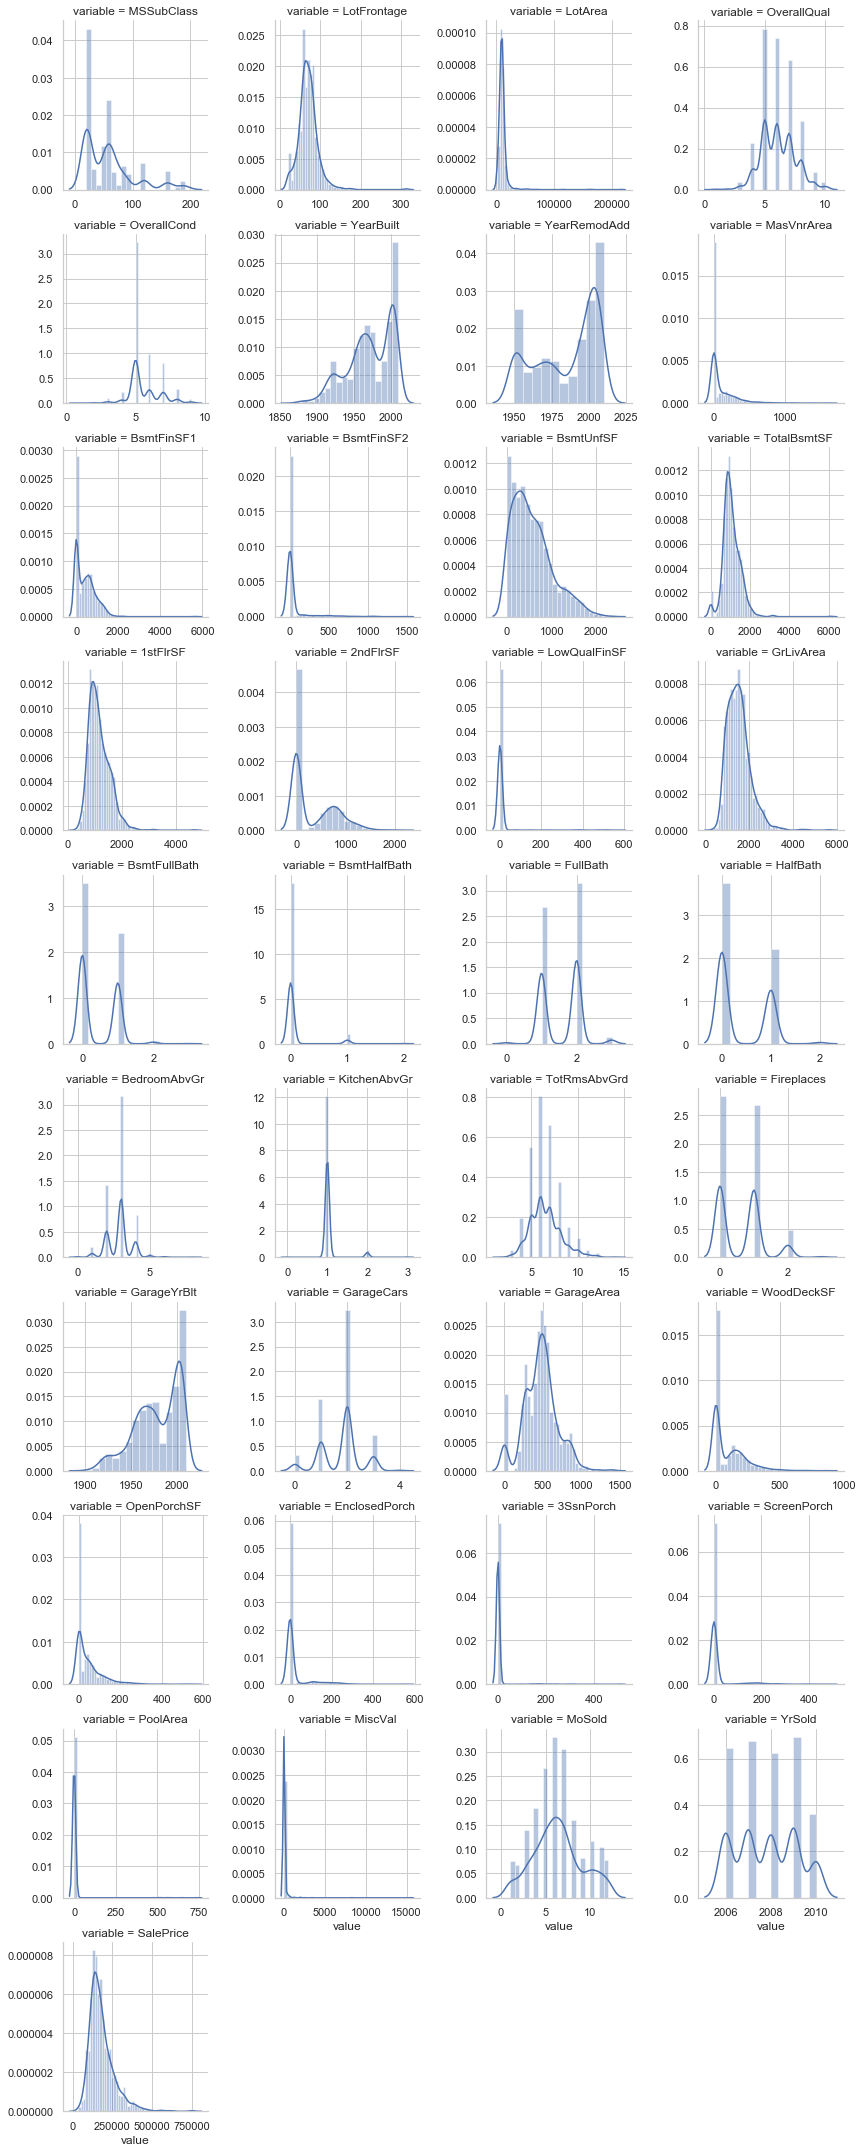

In [60]:
num = [f for f in train.columns if train.dtypes[f] != 'object']
num.remove('Id')
nd = pd.melt(train, value_vars=num)
n1 = sns.FacetGrid(nd, col='variable', col_wrap=4, sharex=False, sharey=False)
n1 = n1.map(sns.distplot, 'value')
n1

__Remark__:<br>
    . most of the variables are right skewed

### Creating boxplots for visualizing categorical variables

e:\python36\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


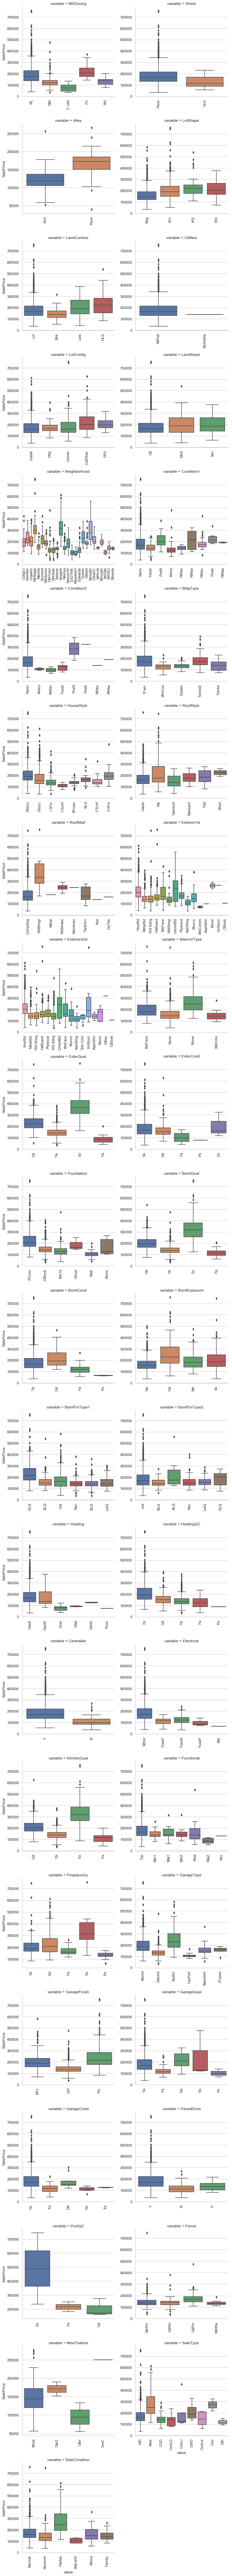

In [61]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x = plt.xticks(rotation=90)

cat = [f for f in train.columns if train.dtypes[f] == 'object']
p = pd.melt(train, id_vars='SalePrice', value_vars=cat)
g = sns.FacetGrid(p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, 'value', 'SalePrice')
g

__Remark__:<br>
    . most of variables possess outlier values

# Data Pre-Processing

### Removing outliers of GrLivArea

In [62]:
print('Before: ', train.shape)
train.drop(train[train['GrLivArea'] > 4000].index, inplace=True)
print('After: ', train.shape) #removed 4 rows`

Before:  (1460, 81)
After:  (1456, 81)


In [74]:
test.loc[666, 'GarageQual'] = "TA" #stats.mode(test['GarageQual']).mode
test.loc[666, 'GarageCond'] = "TA" #stats.mode(test['GarageCond']).mode
test.loc[666, 'GarageFinish'] = "Unf" #stats.mode(test['GarageFinish']).mode
test.loc[666, 'GarageYrBlt'] = "1980" #np.nanmedian(test['GarageYrBlt'])

In [79]:
test.loc[1115, 'GarageType'] = np.nan

1110    Attchd
1111    Attchd
1112    Attchd
1113    Attchd
1114    Detchd
1115       NaN
1116    Detchd
1117    Detchd
1118    Detchd
1119       NaN
Name: GarageType, dtype: object

### Encoding all the categorical variables

In [103]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
def factorize(data, _var, fill_na=None):
    if fill_na is not None:
        data[_var].fillna(fill_na, inplace=True)
    le.fit(data[_var])
    data[_var] = le.transform(data[_var])
    return data

#### Combining the dataset

In [81]:
alldata = train.append(test)
alldata.shape

C:\Users\Dell\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(2915, 81)

In [90]:
lot_frontage_by_neighborhood = train['LotFrontage'].groupby(train['Neighborhood'])
for key, group in lot_frontage_by_neighborhood:
    idx = (alldata['Neighborhood'] == key) & (alldata['LotFrontage'].isnull())
    alldata.loc[idx, 'LotFrontage'] = group.median()

In [94]:
alldata["MasVnrArea"].fillna(0, inplace=True)
alldata["BsmtFinSF1"].fillna(0, inplace=True)
alldata["BsmtFinSF2"].fillna(0, inplace=True)
alldata["BsmtUnfSF"].fillna(0, inplace=True)
alldata["TotalBsmtSF"].fillna(0, inplace=True)
alldata["GarageArea"].fillna(0, inplace=True)
alldata["BsmtFullBath"].fillna(0, inplace=True)
alldata["BsmtHalfBath"].fillna(0, inplace=True)
alldata["GarageCars"].fillna(0, inplace=True)
alldata["GarageYrBlt"].fillna(0.0, inplace=True)
alldata["PoolArea"].fillna(0, inplace=True)

In [95]:
# convert the categorical variables into ordinal variables
# To do this, we'll simply create a dictionary of key-value pairs and map it to the variable in the data set.

qual_dict = {np.nan: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
name = np.array(['ExterQual','PoolQC' ,'ExterCond','BsmtQual','BsmtCond',
                 'HeatingQC','KitchenQual','FireplaceQu', 'GarageQual','GarageCond'])

for i in name:
     alldata[i] = alldata[i].map(qual_dict).astype(int)

In [96]:
alldata["BsmtExposure"] = alldata["BsmtExposure"].map({np.nan: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

bsmt_fin_dict = {np.nan: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
alldata["BsmtFinType1"] = alldata["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
alldata["BsmtFinType2"] = alldata["BsmtFinType2"].map(bsmt_fin_dict).astype(int)
alldata["Functional"] = alldata["Functional"].map({np.nan: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

alldata["GarageFinish"] = alldata["GarageFinish"].map({np.nan: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)
alldata["Fence"] = alldata["Fence"].map({np.nan: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)

In [97]:
alldata["CentralAir"] = (alldata["CentralAir"] == "Y") * 1.0
varst = np.array(['MSSubClass','LotConfig','Neighborhood',
                  'Condition1','BldgType','HouseStyle','RoofStyle','Foundation','SaleCondition'])

for x in varst:
    factorize(alldata, x)

In [104]:
alldata = factorize(alldata, "MSZoning", "RL")
alldata = factorize(alldata, "Exterior1st", "Other")
alldata = factorize(alldata, "Exterior2nd", "Other")
alldata = factorize(alldata, "MasVnrType", "None")
alldata = factorize(alldata, "SaleType", "Oth")

# Feature Engineering
__requires domain knowledge and lots of creative ideas__<br>

Near-zero variance distribution is when one of the categories in a variable has >90% of the values. <br>
We'll create some binary variables depicting the presence or absence of a category. The new features will contain 0 or 1 values.

In [105]:
#creating new variable (1 or 0) based on irregular count levels
#The level with highest count is kept as 1 and rest as 0
alldata["IsRegularLotShape"] = (alldata["LotShape"] == "Reg") * 1
alldata["IsLandLevel"] = (alldata["LandContour"] == "Lvl") * 1
alldata["IsLandSlopeGentle"] = (alldata["LandSlope"] == "Gtl") * 1
alldata["IsElectricalSBrkr"] = (alldata["Electrical"] == "SBrkr") * 1
alldata["IsGarageDetached"] = (alldata["GarageType"] == "Detchd") * 1
alldata["IsPavedDrive"] = (alldata["PavedDrive"] == "Y") * 1
alldata["HasShed"] = (alldata["MiscFeature"] == "Shed") * 1
alldata["Remodeled"] = (alldata["YearRemodAdd"] != alldata["YearBuilt"]) * 1

In [106]:
#Did the modeling happen during the sale year?
alldata["RecentRemodel"] = (alldata["YearRemodAdd"] == alldata["YrSold"]) * 1

In [107]:
# Was this house sold in the year it was built?
alldata["VeryNewHouse"] = (alldata["YearBuilt"] == alldata["YrSold"]) * 1
alldata["Has2ndFloor"] = (alldata["2ndFlrSF"] == 0) * 1
alldata["HasMasVnr"] = (alldata["MasVnrArea"] == 0) * 1
alldata["HasWoodDeck"] = (alldata["WoodDeckSF"] == 0) * 1
alldata["HasOpenPorch"] = (alldata["OpenPorchSF"] == 0) * 1
alldata["HasEnclosedPorch"] = (alldata["EnclosedPorch"] == 0) * 1
alldata["Has3SsnPorch"] = (alldata["3SsnPorch"] == 0) * 1
alldata["HasScreenPorch"] = (alldata["ScreenPorch"] == 0) * 1

In [109]:
#setting levels with high count as 1 and the rest as 0
#you can check for them using the value_counts function
alldata["HighSeason"] = alldata["MoSold"].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
alldata["NewerDwelling"] = alldata["MSSubClass"].replace({20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0, 90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})

In [111]:
alldata.shape

(2915, 100)

In [112]:
#create alldata2
alldata2 = train.append(test)

alldata["SaleCondition_PriceDown"] = alldata2.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# house completed before sale or not
alldata["BoughtOffPlan"] = alldata2.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
alldata["BadHeating"] = alldata2.HeatingQC.replace({'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

C:\Users\Dell\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


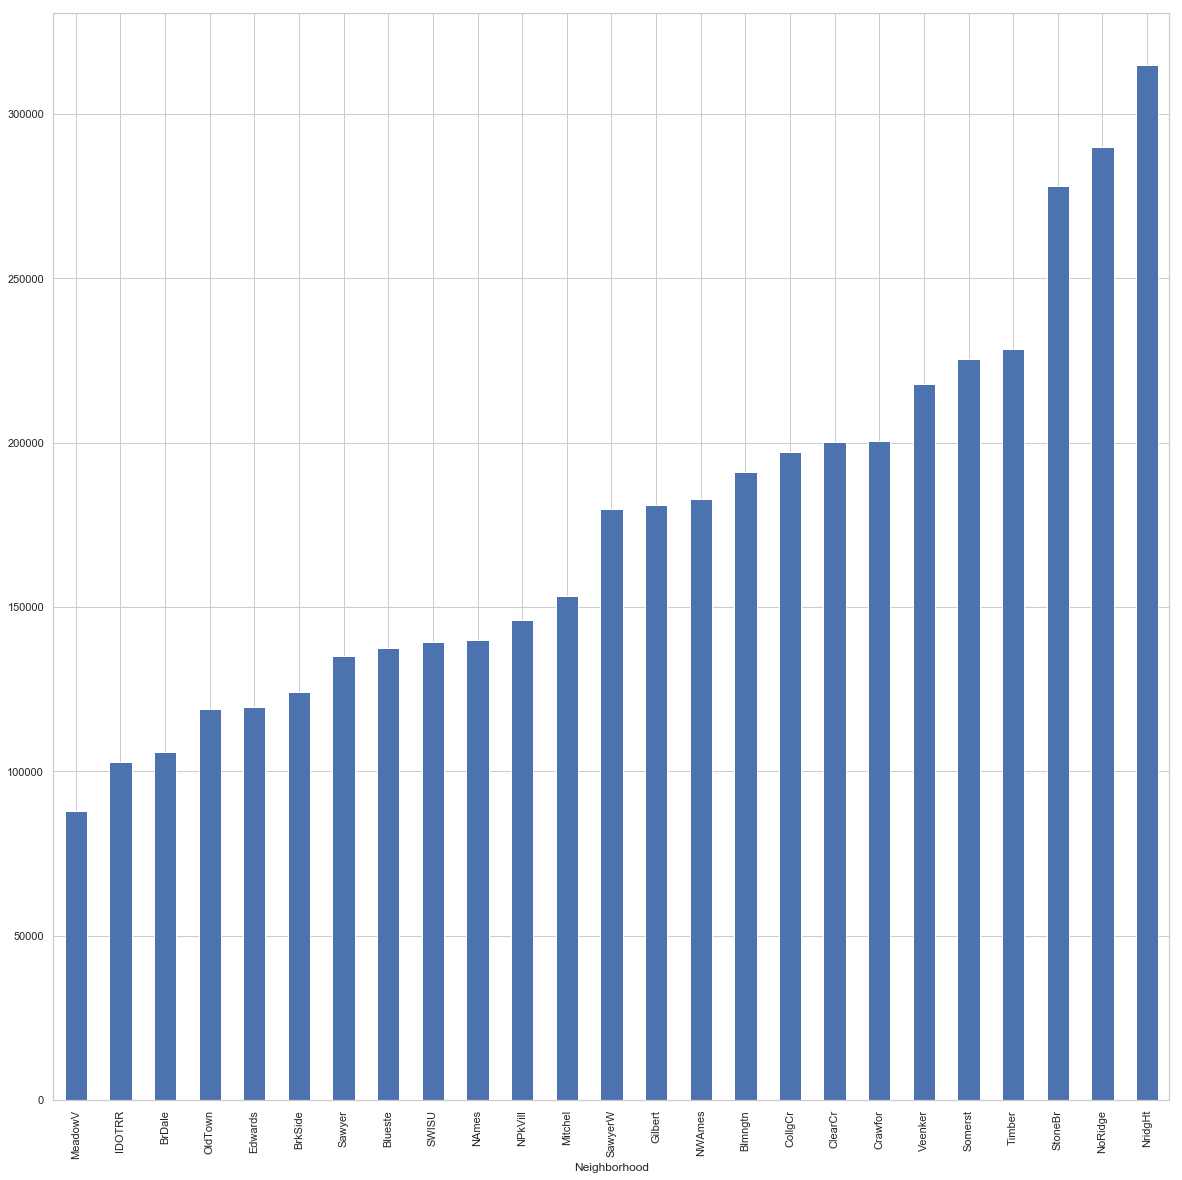

In [115]:
#calculating total area using all area columns
area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 
             'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
             'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF',
             'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]

alldata["TotalArea"] = alldata[area_cols].sum(axis=1)
alldata["TotalArea1st2nd"] = alldata["1stFlrSF"] + alldata["2ndFlrSF"]
alldata["Age"] = 2010 - alldata["YearBuilt"]
alldata["TimeSinceSold"] = 2010 - alldata["YrSold"]
alldata["SeasonSold"] = alldata["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
alldata["YearsSinceRemodel"] = alldata["YrSold"] - alldata["YearRemodAdd"]

# Simplifications of existing features into bad/average/good based on counts
alldata["SimplOverallQual"] = alldata.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
alldata["SimplOverallCond"] = alldata.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
alldata["SimplPoolQC"] = alldata.PoolQC.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2})
alldata["SimplGarageCond"] = alldata.GarageCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplGarageQual"] = alldata.GarageQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplFireplaceQu"] = alldata.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplFireplaceQu"] = alldata.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplFunctional"] = alldata.Functional.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
alldata["SimplKitchenQual"] = alldata.KitchenQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplHeatingQC"] = alldata.HeatingQC.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplBsmtFinType1"] = alldata.BsmtFinType1.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
alldata["SimplBsmtFinType2"] = alldata.BsmtFinType2.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
alldata["SimplBsmtCond"] = alldata.BsmtCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplBsmtQual"] = alldata.BsmtQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplExterCond"] = alldata.ExterCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplExterQual"] = alldata.ExterQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

#grouping neighborhood variable based on this plot
train['SalePrice'].groupby(train['Neighborhood']).median().sort_values().plot(kind='bar')

In [116]:
neighborhood_map = {"MeadowV" : 0, "IDOTRR" : 1, "BrDale" : 1, 
                    "OldTown" : 1, "Edwards" : 1, "BrkSide" : 1,
                    "Sawyer" : 1, "Blueste" : 1, "SWISU" : 2, "NAmes" : 2,
                    "NPkVill" : 2, "Mitchel" : 2, "SawyerW" : 2, "Gilbert" : 2,
                    "NWAmes" : 2, "Blmngtn" : 2, "CollgCr" : 2, "ClearCr" : 3,
                    "Crawfor" : 3, "Veenker" : 3, "Somerst" : 3, "Timber" : 3, "StoneBr" : 4, "NoRidge" : 4, "NridgHt" : 4}

alldata['NeighborhoodBin'] = alldata2['Neighborhood'].map(neighborhood_map)
alldata.loc[alldata2.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
alldata["Neighborhood_Good"].fillna(0, inplace=True)
alldata["SaleCondition_PriceDown"] = alldata2.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# House completed before sale or not
alldata["BoughtOffPlan"] = alldata2.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
alldata["BadHeating"] = alldata2.HeatingQC.replace({'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})
alldata.shape
(2915, 124)

(2915, 124)

In [118]:
train_new = alldata[alldata['SalePrice'].notnull()]
test_new = alldata[alldata['SalePrice'].isnull()]

print('Train: ', train_new.shape)
print ('----------------')
print("Test: ", test_new.shape)

Train:  (1456, 126)
----------------
Test:  (1459, 126)


In [119]:
#get numeric features
numeric_features = [f for f in train_new.columns if train_new[f].dtype != object]

#transform the numeric features using log(x + 1)
from scipy.stats import skew
skewed = train_new[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
train_new[skewed] = np.log1p(train_new[skewed])
test_new[skewed] = np.log1p(test_new[skewed])
del test_new['SalePrice']

C:\Users\Dell\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


### Standardizing 

In [120]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_new[numeric_features])
scaled = scaler.transform(train_new[numeric_features])

for i, col in enumerate(numeric_features):
       train_new[col] = scaled[:,i]

numeric_features.remove('SalePrice')
scaled = scaler.fit_transform(test_new[numeric_features])

for i, col in enumerate(numeric_features):
      test_new[col] = scaled[:,i]

e:\python36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
e:\python36\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


### One-hot encode the categorical variable

In [121]:
def onehot(onehot_df, df, column_name, fill_na):
    onehot_df[column_name] = df[column_name]
    if fill_na is not None:
        onehot_df[column_name].fillna(fill_na, inplace=True)
    dummies = pd.get_dummies(onehot_df[column_name], prefix="_"+column_name)
    onehot_df = onehot_df.join(dummies)
    onehot_df = onehot_df.drop([column_name], axis=1)
    return onehot_df

def munge_onehot(df):
    onehot_df = pd.DataFrame(index = df.index)

    onehot_df = onehot(onehot_df, df, "MSSubClass", None)
    onehot_df = onehot(onehot_df, df, "MSZoning", "RL")
    onehot_df = onehot(onehot_df, df, "LotConfig", None)
    onehot_df = onehot(onehot_df, df, "Neighborhood", None)
    onehot_df = onehot(onehot_df, df, "Condition1", None)
    onehot_df = onehot(onehot_df, df, "BldgType", None)
    onehot_df = onehot(onehot_df, df, "HouseStyle", None)
    onehot_df = onehot(onehot_df, df, "RoofStyle", None)
    onehot_df = onehot(onehot_df, df, "Exterior1st", "VinylSd")
    onehot_df = onehot(onehot_df, df, "Exterior2nd", "VinylSd")
    onehot_df = onehot(onehot_df, df, "Foundation", None)
    onehot_df = onehot(onehot_df, df, "SaleType", "WD")
    onehot_df = onehot(onehot_df, df, "SaleCondition", "Normal")

       #Fill in missing MasVnrType for rows that do have a MasVnrArea.
    temp_df = df[["MasVnrType", "MasVnrArea"]].copy()
    idx = (df["MasVnrArea"] != 0) & ((df["MasVnrType"] == "None") | (df["MasVnrType"].isnull()))
    temp_df.loc[idx, "MasVnrType"] = "BrkFace"
    onehot_df = onehot(onehot_df, temp_df, "MasVnrType", "None")

    onehot_df = onehot(onehot_df, df, "LotShape", None)
    onehot_df = onehot(onehot_df, df, "LandContour", None)
    onehot_df = onehot(onehot_df, df, "LandSlope", None)
    onehot_df = onehot(onehot_df, df, "Electrical", "SBrkr")
    onehot_df = onehot(onehot_df, df, "GarageType", "None")
    onehot_df = onehot(onehot_df, df, "PavedDrive", None)
    onehot_df = onehot(onehot_df, df, "MiscFeature", "None")
    onehot_df = onehot(onehot_df, df, "Street", None)
    onehot_df = onehot(onehot_df, df, "Alley", "None")
    onehot_df = onehot(onehot_df, df, "Condition2", None)
    onehot_df = onehot(onehot_df, df, "RoofMatl", None)
    onehot_df = onehot(onehot_df, df, "Heating", None)

       # we'll have these as numerical variables too
    onehot_df = onehot(onehot_df, df, "ExterQual", "None")
    onehot_df = onehot(onehot_df, df, "ExterCond", "None")
    onehot_df = onehot(onehot_df, df, "BsmtQual", "None")
    onehot_df = onehot(onehot_df, df, "BsmtCond", "None")
    onehot_df = onehot(onehot_df, df, "HeatingQC", "None")
    onehot_df = onehot(onehot_df, df, "KitchenQual", "TA")
    onehot_df = onehot(onehot_df, df, "FireplaceQu", "None")
    onehot_df = onehot(onehot_df, df, "GarageQual", "None")
    onehot_df = onehot(onehot_df, df, "GarageCond", "None")
    onehot_df = onehot(onehot_df, df, "PoolQC", "None")
    onehot_df = onehot(onehot_df, df, "BsmtExposure", "None")
    onehot_df = onehot(onehot_df, df, "BsmtFinType1", "None")
    onehot_df = onehot(onehot_df, df, "BsmtFinType2", "None")
    onehot_df = onehot(onehot_df, df, "Functional", "Typ")
    onehot_df = onehot(onehot_df, df, "GarageFinish", "None")
    onehot_df = onehot(onehot_df, df, "Fence", "None")
    onehot_df = onehot(onehot_df, df, "MoSold", None)

       # Divide  the years between 1871 and 2010 into slices of 20 years
    year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20))  for i in range(0, 7))
    yearbin_df = pd.DataFrame(index = df.index)
    yearbin_df["GarageYrBltBin"] = df.GarageYrBlt.map(year_map)
    yearbin_df["GarageYrBltBin"].fillna("NoGarage", inplace=True)
    yearbin_df["YearBuiltBin"] = df.YearBuilt.map(year_map)
    yearbin_df["YearRemodAddBin"] = df.YearRemodAdd.map(year_map)

    onehot_df = onehot(onehot_df, yearbin_df, "GarageYrBltBin", None)
    onehot_df = onehot(onehot_df, yearbin_df, "YearBuiltBin", None)
    onehot_df = onehot(onehot_df, yearbin_df, "YearRemodAddBin", None)
    return onehot_df

#create one-hot features
onehot_df = munge_onehot(train)

neighborhood_train = pd.DataFrame(index=train_new.shape)
neighborhood_train['NeighborhoodBin'] = train_new['NeighborhoodBin']
neighborhood_test = pd.DataFrame(index=test_new.shape)
neighborhood_test['NeighborhoodBin'] = test_new['NeighborhoodBin']

onehot_df = onehot(onehot_df, neighborhood_train, 'NeighborhoodBin', None)

In [122]:
train_new = train_new.join(onehot_df) 
train_new.shape

(1456, 433)

In [123]:
onehot_df_te = munge_onehot(test)
onehot_df_te = onehot(onehot_df_te, neighborhood_test, "NeighborhoodBin", None)
test_new = test_new.join(onehot_df_te)
test_new.shape

(1459, 417)

The difference in number of train and test columns suggests that some new features in the train data aren't available in the test data. Let's remove those variables and keep an equal number of columns in the train and test data.

In [124]:
drop_cols = ["_Exterior1st_ImStucc", "_Exterior1st_Stone","_Exterior2nd_Other","_HouseStyle_2.5Fin","_RoofMatl_Membran", "_RoofMatl_Metal", "_RoofMatl_Roll", "_Condition2_RRAe", "_Condition2_RRAn", "_Condition2_RRNn", "_Heating_Floor", "_Heating_OthW", "_Electrical_Mix", "_MiscFeature_TenC", "_GarageQual_Ex",  "_PoolQC_Fa"]
train_new.drop(drop_cols, axis=1, inplace=True)
train_new.shape

(1456, 417)

Now, we have an equal number of columns in the train and test data. Here, we'll remove a few more columns which either have lots of zeroes (hence doesn't provide any real information) or aren't available in either of the data sets.

In [125]:
#removing one column missing from train data
test_new.drop(["_MSSubClass_150"], axis=1, inplace=True)

# Drop these columns
drop_cols = ["_Condition2_PosN", # only two are not zero
         "_MSZoning_C (all)",
         "_MSSubClass_160"]

train_new.drop(drop_cols, axis=1, inplace=True)
test_new.drop(drop_cols, axis=1, inplace=True)

In [126]:
#create a label set
label_df = pd.DataFrame(index = train_new.index, columns = ['SalePrice'])
label_df['SalePrice'] = np.log(train['SalePrice'])
print("Training set size:", train_new.shape)
print("Test set size:", test_new.shape)

Training set size: (1456, 414)
Test set size: (1459, 413)


# Model Training and Evaluation

In [131]:
import xgboost as xgb
regr = xgb.XGBRegressor(colsample_bytree=0.2,
                       gamma=0.0,
                       learning_rate=0.05,
                       max_depth=6,
                       min_child_weight=1.5,
                       n_estimators=7200,
                       reg_alpha=0.9,
                       reg_lambda=0.6,
                       subsample=0.2,
                       seed=42,
                       silent=1)

regr.fit(train_new, label_df)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Alley, Condition2, Electrical, GarageType, Heating, LandContour, LandSlope, LotShape, MiscFeature, PavedDrive, RoofMatl, Street, Utilities